# Import libraries

In [1]:
!pip install googlemaps

  Preparing metadata (setup.py) ... done
  Created wheel for googlemaps: filename=googlemaps-4.10.0-py3-none-any.whl size=40711 sha256=8267b470dbcf9a54fe8bf78367c1fdceb0c3a639c49ec025a3ee15bd3146f2f1
  Stored in directory: /root/.cache/pip/wheels/17/f8/79/999d5d37118fd35d7219ef57933eb9d09886c4c4503a800f84
Successfully built googlemaps


In [2]:
!pip install hdbscan


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 40.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039287 sha256=94354be32ffe55262b2cbbd453c5f360bae93fef9fba16ecf12a63a8bd77452d
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.8
    Uninstalling Cython-3.0.8:
      Successfully uninstalled Cython-3.0.8


In [3]:
!pip install folium

In [4]:
import pandas as pd
import numpy as np
import logging

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import folium
import matplotlib.cm as cm

from matplotlib import cm, colors as mcolors
from sklearn.cluster import DBSCAN
import hdbscan


import googlemaps
from datetime import datetime

from sklearn.metrics import silhouette_score, silhouette_samples

from math import radians, cos, sin, asin, sqrt

import joblib

import time
import os

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# the directory where on_lift_events datasets are stored. Please adjust this for your own repo
data_path = '/content/'

In [7]:
# import all CSV files in the directory ending with 'on_lift_events'
csv_files = [file for file in os.listdir(data_path) if file.endswith('on_lift_events.csv')]

In [8]:
csv_files

['df_310_on_lift_events.csv',
 'df_290_on_lift_events.csv',
 'df_135_on_lift_events.csv',
 'df_166_on_lift_events.csv',
 'df_206_on_lift_events.csv',
 'df_100_on_lift_events.csv',
 'df_131_on_lift_events.csv']

In [9]:
# an empty list to store your DataFrames
dataframes_list = []

# Loop through the CSV files and read each one into a DataFrame
for file in csv_files:
    file_path = os.path.join(data_path, file)
    df = pd.read_csv(file_path)
    dataframes_list.append(df)


In [10]:
dataframes_list[0]

,Timestamp,accelX(g),accelY(g),accelZ(g),accelUserX(g),accelUserY(g),accelUserZ(g),gyroX(rad/s),gyroY(rad/s),gyroZ(rad/s),...,magZ(µT),calMagX(µT),calMagY(µT),calMagZ(µT),Alt(m)_change,Speed(m/s)_change,Course_change,predicted,mask,event
0,2023-04-08 08:25:39,0.1469,-0.5016,-0.6164,-0.0205,0.0419,0.2105,-0.2433,-0.1863,0.1109,...,-81.2584,2.0595,-32.6295,-32.3720,0.000000,0.00,0.0,0,1.0,1
1,2023-04-08 08:25:40,0.1552,-0.5138,-0.7686,0.0539,-0.0730,0.1244,-0.2232,0.2461,0.0555,...,-76.2836,11.9967,-32.6897,-27.5039,15.920899,0.83,-2.8,1,1.0,1
2,2023-04-08 08:25:41,0.1574,-0.6052,-0.8676,0.0057,0.0007,-0.0876,0.0985,-0.2090,0.0404,...,-71.0870,11.1734,-44.5715,-21.9304,6.374756,-0.66,0.0,1,1.0,1
3,2023-04-08 08:25:43,0.3829,-1.1274,0.5387,0.0678,-0.2406,0.3286,-0.4226,-0.4921,-0.7779,...,-28.8152,15.7277,-39.5037,20.0695,3.253784,1.18,6.7,1,1.0,1
4,2023-04-08 08:25:44,0.5455,-0.9876,-0.0720,0.1791,-0.0073,-0.2420,0.1047,0.4837,2.8508,...,-38.4458,12.2346,-44.4381,10.6295,2.300049,-1.18,-3.2,0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18432,2023-04-08 13:36:22,-0.1306,-0.4372,-1.0096,-0.1329,-0.0651,-0.0815,0.6196,0.5358,-0.1787,...,-83.9174,-12.1714,-35.7323,-31.8777,-0.103271,0.00,0.0,0,0.0,0
18433,2023-04-08 13:36:23,0.0719,-0.4624,-0.8884,-0.0267,0.0056,-0.0102,0.0011,-0.0850,-0.5501,...,-79.2239,-6.8547,-40.1080,-27.4827,-0.590820,0.00,0.0,0,0.0,0
18434,2023-04-08 13:36:24,-0.1669,-0.7570,-0.5373,-0.3806,-0.2018,0.2665,5.2579,-2.0120,0.9900,...,-72.0463,2.9559,-43.3942,-19.9750,-0.210572,0.00,0.0,0,0.0,0
18435,2023-04-08 13:36:25,0.2455,-0.1281,-1.1840,0.1035,-0.0669,-0.1960,-0.0707,-0.5946,-0.3314,...,-92.9536,-3.0172,-24.6688,-41.0723,0.214478,0.00,0.0,0,0.0,0


In [ ]:
#df.info for all datasets

for i, df in enumerate(dataframes_list):
    print(f"DataFrame {i+1} Info:")
    df.info()
    print("\n")

**Get Geocoded location names, start and end altitude, slope, duration of rides**

In [15]:
# Initialize Google Maps client with your API key
gmaps = googlemaps.Client(key='Your API KEY')

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in meters between two points
    on the earth (specified in decimal degrees).
    """
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of Earth in kilometers.
    return c * r * 1000  # Return distance in meters

def safe_reverse_geocode(lat, lng, client):
    try:
        response = client.reverse_geocode((lat, lng))
        return response[0]['formatted_address'] if response else 'Unknown Location'
    except Exception as e:
        print(f"Error during reverse geocoding: {e}")
        return 'Unknown Location'

def process_dataset(df, gmaps):
    #df=df[df['event']!=0]

    df['Timestamp'] = pd.to_datetime(df['Timestamp'])

    # Calculate start and end times, and duration
    event_times = df.groupby('event')['Timestamp'].agg(['min', 'max']).reset_index()
    event_times['Duration'] = event_times['max'] - event_times['min']


    # Calculate start and end points for Latitude, Longitude, and Altitude
    start_points = df.groupby('event').agg({'Lat': 'first', 'Long': 'first', 'Alt(m)': 'first'}).reset_index().rename(columns={'Lat': 'Lat_start', 'Long': 'Long_start', 'Alt(m)': 'Start_Altitude'})
    end_points = df.groupby('event').agg({'Lat': 'last', 'Long': 'last', 'Alt(m)': 'last'}).reset_index().rename(columns={'Lat': 'Lat_end', 'Long': 'Long_end', 'Alt(m)': 'End_Altitude'})

    # Merge all information
    event_summary = pd.merge(start_points, end_points, on='event')
    event_summary = pd.merge(event_summary, event_times, on='event')

    # Calculate the geographic distance for each event using haversine
    event_summary['Distance_meters'] = event_summary.apply(lambda row: haversine(row['Long_start'], row['Lat_start'], row['Long_end'], row['Lat_end']), axis=1)

    # Calculate altitude difference
    event_summary['Altitude_Difference'] = event_summary['End_Altitude'] - event_summary['Start_Altitude']

    # Approximate slope calculation (altitude difference over geographic distance)
    event_summary['Gradient'] = event_summary.apply(lambda row: row['Altitude_Difference'] / row['Distance_meters'] if row['Distance_meters'] != 0 else 0, axis=1)

    # Calculate averages for 'Speed(m/s)' for each event
    avg_speed = df.groupby('event')['Speed(m/s)'].mean().reset_index().rename(columns={'Speed(m/s)': 'Avg_Speed'})

    # Merge speed information
    event_summary = pd.merge(event_summary, avg_speed, on='event')

    # Reverse geocode locations
    event_summary['StartLocation'] = event_summary.apply(lambda row: safe_reverse_geocode(row['Lat_start'], row['Long_start'], gmaps), axis=1)
    event_summary['EndLocation'] = event_summary.apply(lambda row: safe_reverse_geocode(row['Lat_end'], row['Long_end'], gmaps), axis=1)

    return event_summary

processed_summaries = []
for df in dataframes_list:
    processed_summary = process_dataset(df, gmaps)
    processed_summaries.append(processed_summary)


In [ ]:
type(processed_summaries[0])

In [17]:
 # List to hold the final DataFrames
final_dfs = []

# columns to keep
columns_to_keep = ['event', 'Duration', 'Distance_meters', 'Start_Altitude','End_Altitude', 'Gradient', 'Avg_Speed',
                   'Lat_start', 'Long_start', 'Lat_end', 'Long_end','StartLocation', 'EndLocation']

for summary in processed_summaries:
    final_df = summary[columns_to_keep]
    final_dfs.append(final_df)

In [18]:
# drop observations of 0 for all datasets
filtered_dfs = [df[df['event'] != 0] for df in final_dfs]


In [19]:
# Concatenate all on_lift_events datasets vertically
combined_df_onlist_events = pd.concat(filtered_dfs, axis=0)
combined_df_onlist_events

,event,Duration,Distance_meters,Start_Altitude,End_Altitude,Gradient,Avg_Speed,Lat_start,Long_start,Lat_end,Long_end,StartLocation,EndLocation
1,1,0 days 00:02:02,623.812768,2025.420776,2212.624268,0.300096,5.045793,46.623842,8.595877,46.618484,8.598298,"JHFW+G9 Andermatt, Switzerland","Gemsstock Mittelstation, 6490 Andermatt, Switz..."
2,2,0 days 00:04:01,1895.576254,2223.582275,2936.921875,0.376318,7.888926,46.617668,8.599178,46.602773,8.611248,"Gemsstock Mittelstation, 6490 Andermatt, Switz...","Gemsstock, 6490 Andermatt, Switzerland"
3,3,0 days 00:04:04,1592.697864,1443.725464,2205.269531,0.478147,6.331283,46.632253,8.591892,46.618627,8.598321,"Andermatt, 6490 Andermatt, Switzerland","Gemsstock Mittelstation, 6490 Andermatt, Switz..."
4,4,0 days 00:05:01,2013.786223,2208.248291,2946.988037,0.366841,6.637962,46.618289,8.598693,46.602466,8.611518,"Gemsstock Mittelstation, 6490 Andermatt, Switz...","Gemsstock, 6490 Andermatt, Switzerland"
5,5,0 days 00:04:01,809.266267,2022.098022,2269.097412,0.305214,3.292488,46.624565,8.599357,46.617432,8.597253,"JHFX+RP Andermatt, Switzerland","Gemsstock Mittelstation, 6490 Andermatt, Switz..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,2,0 days 00:07:00,1598.784859,1849.567261,2346.978027,0.311118,3.794189,46.643357,8.607857,46.655037,8.620072,"JJV5+84 Andermatt, Switzerland","Gütsch (Bergst. Andermatt), 6490 Andermatt, Sw..."
3,3,0 days 00:03:00,519.586126,2187.378906,2360.833496,0.333832,3.081035,46.653236,8.626955,46.656582,8.622203,"MJ3G+7Q Andermatt, Switzerland","Gütsch, 6490 Andermatt, Switzerland"
4,4,0 days 00:04:00,590.779560,2163.722656,2359.300537,0.331051,2.647379,46.652856,8.627716,46.656622,8.622256,"MJ3H+43 Andermatt, Switzerland","Gütsch, 6490 Andermatt, Switzerland"
5,5,0 days 00:04:00,575.743910,2158.855957,2362.215576,0.353212,2.690217,46.652893,8.627792,46.656507,8.622390,"MJ3H+54 Andermatt, Switzerland","Gütsch, 6490 Andermatt, Switzerland"


In [20]:
unique= combined_df_onlist_events['event'].unique()
unique

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

**Clustering using Hierarchical DBSCAN.** HDBSCAN is an advanced clustering algorithm that extends DBSCAN by converting it into a hierarchical clustering algorithm, and then using a technique to extract flat clusters based on the stability of clusters

In [21]:
# only numeric columns for clustering
numeric_columns = ['Start_Altitude', 'End_Altitude','Lat_start','Long_start', 'Lat_end', 'Long_end']
data_for_clustering = combined_df_onlist_events[numeric_columns]


In [22]:
# Applying HDBSCAN
hdb = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=4)
cluster_labels = hdb.fit_predict(data_for_clustering)


In [23]:
combined_df_onlist_events['ClusterHDB_Labels'] = cluster_labels

In [24]:
# Summary statistics for clusters
combined_df_onlist_events['ClusterHDB_Labels'].value_counts()

-1    13
 3    12
 0    10
 4    10
 1     6
 2     6
 5     5
Name: ClusterHDB_Labels, dtype: int64

In [25]:
combined_df_onlist_events['ClusterHDB_Labels'].value_counts(normalize=True)*100

-1    20.967742
 3    19.354839
 0    16.129032
 4    16.129032
 1     9.677419
 2     9.677419
 5     8.064516
Name: ClusterHDB_Labels, dtype: float64

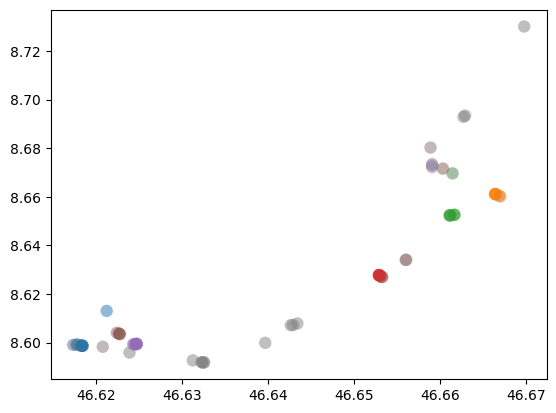

In [26]:
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}
palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat) if col >= 0 else (0.5, 0.5, 0.5) for col, sat in zip(hdb.labels_, hdb.probabilities_)]

plt.scatter(data_for_clustering.values[:, 2], data_for_clustering.values[:, 3], c=cluster_colors, **plot_kwds)
plt.show()


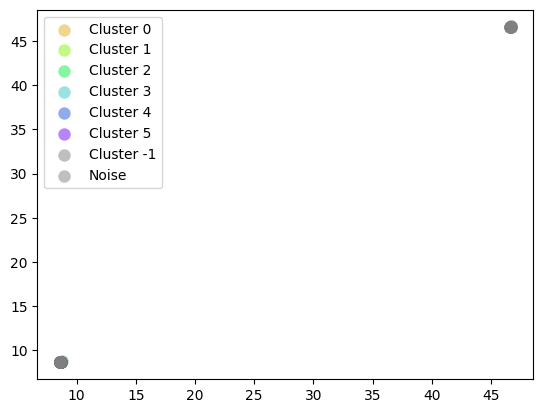

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Your existing setup for plot keywords and palette
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}
palette = sns.color_palette('hsv', len(set(hdb.labels_)))

# Assuming 'hdb.labels_' are your HDBSCAN cluster labels
# and 'hdb.probabilities_' are the probabilities or strengths of cluster membership
# Assuming 'data_for_clustering' is a DataFrame with your clustering data

# First, create a scatter plot for each cluster
for cluster_label in set(hdb.labels_):
    # Get a boolean mask for the current cluster
    mask = hdb.labels_ == cluster_label
    # Get the color for the current cluster
    cluster_color = sns.desaturate(palette[cluster_label], np.mean(hdb.probabilities_[mask]))
    # Plot the points belonging to the current cluster with the corresponding color and label
    plt.scatter(data_for_clustering.values[mask, 3],
                data_for_clustering.values[mask, 3],
                c=[cluster_color],
                label=f'Cluster {cluster_label}',
                **plot_kwds)

# Handle plotting noise points (label=-1) if they exist
if -1 in hdb.labels_:
    mask = hdb.labels_ == -1
    plt.scatter(data_for_clustering.values[mask, 4],
                data_for_clustering.values[mask, 4],
                color='grey',
                label='Noise',
                **plot_kwds)

# Finally, show the legend
plt.legend()

# Show the plot
plt.show()


In [83]:
#combined_df_onlist_events

**Evaluating the HDBSCAN**

In [28]:
# 1. Silhouette score without masking the -1 labels identified as noise by HDBSCAN
labels= combined_df_onlist_events['ClusterHDB_Labels']
# Calculate the silhouette score
score = silhouette_score(data_for_clustering, labels)

print("Silhouette Score: ", score)


Silhouette Score:  0.5965816749143252


In [29]:
# 2. Silhouette score with masking the -1 labels identified as noise by HDBSCAN

# Filter out noise points for silhouette score calculation
mask = cluster_labels != -1
filtered_data = data_for_clustering[mask]
filtered_labels = cluster_labels[mask]

# Calculate the silhouette score
score = silhouette_score(filtered_data, filtered_labels)

print("Silhouette Score: ", score)


Silhouette Score:  0.7723961261310316


In [ ]:
#combined_df_onlist_events.columns

In [30]:
df_alt_duration=combined_df_onlist_events.drop(columns=['event','Avg_Speed', 'Gradient', 'Distance_meters'])
df_long_speed=combined_df_onlist_events.drop(columns=['event','Distance_meters', 'Start_Altitude', 'End_Altitude','Lat_start','Long_start', 'Lat_end', 'Long_end'])


In [31]:
#calculate cluster mean for altitude and duration
mean_by_cluster=df_alt_duration.groupby('ClusterHDB_Labels').mean()
mean_by_cluster

<ipython-input-31-c04fcc7c08fb>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_by_cluster=df_alt_duration.groupby('ClusterHDB_Labels').mean()


,Start_Altitude,End_Altitude,Lat_start,Long_start,Lat_end,Long_end
ClusterHDB_Labels,,,,,,
-1,1679.759399,2152.236647,46.642174,8.622647,46.640216,8.625965
0,2215.893579,2940.473584,46.618389,8.600258,46.602478,8.611565
1,2425.065389,2591.215657,46.666544,8.660819,46.669325,8.656136
2,2151.809652,2589.628784,46.661321,8.655300,46.669336,8.656080
3,2163.098002,2356.456217,46.651291,8.630507,46.654540,8.627749
4,2029.734863,2287.855347,46.634894,8.621426,46.629644,8.623233
5,2033.415356,2380.924072,46.630140,8.617261,46.626815,8.624149


In [32]:
#calculate cluster mean for longitude and speed
mean_by_cluster2=df_long_speed.groupby('ClusterHDB_Labels').mean()
mean_by_cluster2

<ipython-input-32-7574920d0246>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_by_cluster2=df_long_speed.groupby('ClusterHDB_Labels').mean()


,Gradient,Avg_Speed
ClusterHDB_Labels,,
-1,0.364331,4.669790
0,0.363116,4.733526
1,0.351604,3.766801
2,0.435546,3.426545
3,0.337995,3.195082
4,0.302662,3.715562
5,0.338916,3.062909


In [ ]:
# ignore this plot code ----

custom_colors = cm.get_cmap('tab20', 12)

# Create a figure with 2 subplots stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8))  # Adjust the figsize as needed

# Plot the first set of means on the first subplot (ax1)
mean_by_cluster.plot(kind='bar', ax=ax1, cmap=custom_colors)
ax1.legend(bbox_to_anchor=(1.02, 1.02), fontsize='large')
ax1.set_xlabel('Ski categories')
ax1.set_xticklabels(mean_by_cluster.index, rotation=0)
ax1.set_ylabel('Average values')
ax1.set_title('Ski categories by altitude and distance')

# Plot the second set of means on the second subplot (ax2)
mean_by_cluster2.plot(kind='bar', ax=ax2, cmap=custom_colors)
ax2.legend(bbox_to_anchor=(1.02, 1.02), fontsize='large')
ax2.set_xlabel('Ski categories')
ax2.set_xticklabels(mean_by_cluster2.index, rotation=0)
ax2.set_ylabel('Average values')
ax2.set_title('Ski categories by slope and speed')

# The layout
plt.tight_layout()
plt.show()

In [34]:
# Create a color map with a distinct color for each cluster label


cluster_labels = combined_df_onlist_events['ClusterHDB_Labels']
unique_labels = np.unique(cluster_labels)
colors = cm.rainbow(np.linspace(0, 1, len(unique_labels)))
color_dict = dict(zip(unique_labels, colors))

# Initialize the map at the mean location of the start points
mean_lat = combined_df_onlist_events['Lat_start'].mean()
mean_lon = combined_df_onlist_events['Long_start'].mean()
m = folium.Map(location=[mean_lat, mean_lon], zoom_start=12)

# Add points to the map
for _, row in combined_df_onlist_events.iterrows():
    # Assign a color from the color map
    color = color_dict[row['ClusterHDB_Labels']]

    # Convert RGBA color to HEX
    color = mcolors.rgb2hex(color)

    # Plot start point
    folium.CircleMarker(
        location=(row['Lat_start'], row['Long_start']),
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"Cluster: {row['ClusterHDB_Labels']}"
    ).add_to(m)

    # Plot end point
    folium.CircleMarker(
        location=(row['Lat_end'], row['Long_end']),
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"Cluster: {row['ClusterHDB_Labels']}"
    ).add_to(m)

# Display the map
m
